In [0]:
import tensorflow as tf
import os

from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.utils import to_categorical 

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, X_test.shape

170500096/170498071 [==============================] - 18s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

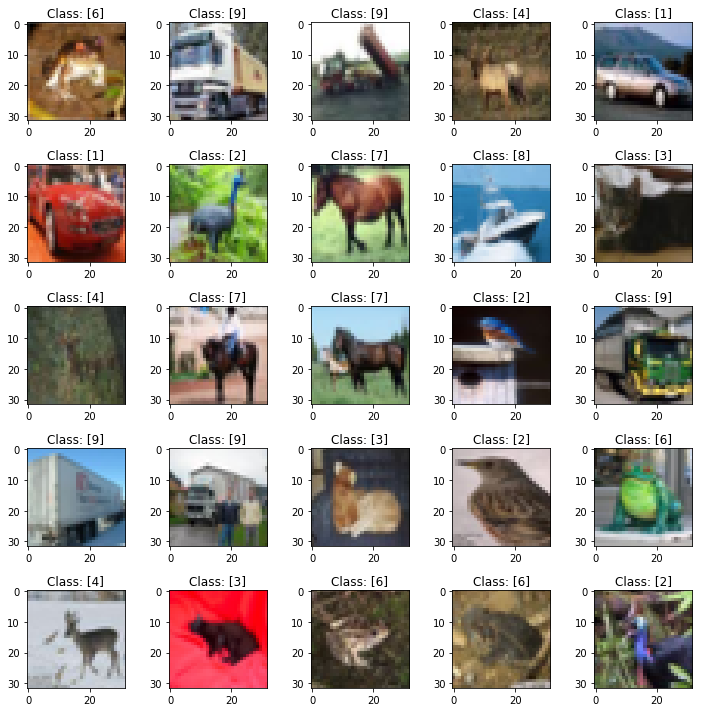

In [0]:
plt.figure(figsize=(10,10))
for idx in range(25):
    plt.subplot(5, 5, idx+1)
    plt.imshow(X_train[idx], cmap="gray")
    plt.title("Class: {}".format(y_train[idx]))
    
plt.tight_layout()    

In [3]:
# add dimention
img_rows, img_cols = X_train.shape[1], X_train.shape[1]

num_channels = 3
X_train = X_train.reshape(-1, img_rows, img_cols, num_channels)
X_test = X_test.reshape(-1, img_rows, img_cols, num_channels)

input_shape = (img_rows, img_cols, num_channels)

X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
# normalize X
if np.max(X_train) > 1: X_train = X_train / 255
if np.max(X_test) > 1: X_test = X_test / 255

In [0]:
# reshape
if len(y_train.shape) == 2:
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)

# change y values to list of values
if len(y_train.shape) == 1:
    num_classes = len(set(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

In [7]:
y_train.shape, y_test.shape, num_classes

((50000, 10), (10000, 10), 10)

In [8]:
# model architecture
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), 
           activation="relu",
           input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3),
          activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=64, kernel_size=(3,3),
          activation="relu"),
    Conv2D(filters=64, kernel_size=(3,3),
          activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3,3),
          activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)    

In [0]:
# connect to TPU
TPU_WORKER = "grpc://" + os.environ["COLAB_TPU_ADDR"]
tf.logging.set_verbosity(tf.logging.INFO)

In [11]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.8.113.98:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13906099367770918232)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7025079691398184413)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4261486900814727096)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1,

In [12]:
# train
tpu_model.fit(
    X_train, y_train,
    batch_size=128 * 8,
    epochs=20,
    validation_split=0.2
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(128, 10), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7efc34bc4748> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.82448410987854 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU l

In [14]:
tpu_model.evaluate(X_train, y_train)

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(4, 10), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7efc30a86358> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.029249668121338 secs
49824/50000 [============================>.] - ETA: 0s - loss: 1.5778 - acc: 0.4692INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(2, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(2, 10), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default pla

[1.5775059202957153, 0.46936]